In [15]:
import PIL
print('Pillow Version:', PIL.__version__)

Pillow Version: 5.4.1


In [16]:
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
import keras.preprocessing.image as preprocess
from DataGenerator import *

In [17]:
# importing images
#path = "/home/hippoc/schen/imgs_colors/"
path = "/home/hippoc/bin/beauvoir/data/crop_data/300x200/"

#image_num = 8000
#images = np.zeros((image_num, 200, 300, 3))
#for i in range(image_num):
#    img = preprocess.load_img(path + str(i)+'.png')
#    img_array = preprocess.img_to_array(img)
#    images[i] = img_array
    
# preprocessing images (range from 0 to 1)
#images /= 255.0

#datagen = ImageDataGenerator(
#        featurewise_center=True,
#        samplewise_center=False,
#        featurewise_std_normalization=True,
#        samplewise_std_normalization=False,
#        zca_whitening=True,
#        rotation_range=0,
#        width_shift_range=0,
#        height_shift_range=0,
#        horizontal_flip=False,
#        vertical_flip=False
#        )



In [18]:
input_shape = (200, 300, 3)

#image_num = 58500
image_num = 1600
training_labels = (1, 1250)
validation_labels = (1250, 1600)
partition = {}
partition['train'] = list(range(training_labels[0], training_labels[1]))
partition['validation'] = list(range(validation_labels[0], validation_labels[1]))

In [19]:
# importing labels
f = open(path + 'labels.txt', 'r')
labels = f.readlines()
labels = [eval(x.strip()) for x in labels]

# change labels to range from 0-num of pixels
labels = [(x[0] * 300, x[1] * 200) for x in labels]
print(len(labels))


# preprocessing labels (range from -1 to 1)
labels_orig = np.round(np.array([[tup[0], tup[1]] for tup in labels]))
labels = [[(tup[0]-(input_shape[1]/2))/(input_shape[1]/2), (tup[1]-(input_shape[0]/2))/-(input_shape[0]/2)] for tup in labels]
labels = np.array(labels)
labels_dict = {}
for i in range(image_num):
    labels_dict[i] = labels[i]

1993


In [20]:
# VERIFY THAT IMAGES ARE LABELLED CORRECTLY 
# puts a cross on the supposed center and saves it to folder "orig_labels"

from PIL import ImageDraw

for i in range(200):
    img = Image.open(path + str(i)+'.png')
    draw = ImageDraw.Draw(img)
    
    pred = labels_orig[i]
    
    draw.line([tuple(pred - [10, 0]), tuple(pred + [10, 0])], fill="blue", width=3)
    draw.line([tuple(pred - [0, 10]), tuple(pred + [0, 10])], fill="red", width=3)

#    draw.point(labels_orig[i], fill="blue")
#    draw.point(preds[i-12000], fill="black")
    print(labels_orig[i])
    img.save(path + "orig_labels/" + str(i) + "_label.png")

[177. 127.]
[174. 106.]
[84. 99.]
[137.  75.]
[189.  62.]
[115.  91.]
[134. 131.]
[145.  93.]
[122.  90.]
[153. 114.]
[183. 104.]
[166.  73.]
[164.  91.]
[155. 117.]
[146. 119.]
[121. 136.]
[141.  73.]
[141.  75.]
[160.  83.]
[143.  73.]
[119.  90.]
[169.  71.]
[155.  83.]
[156. 117.]
[160. 115.]
[187. 117.]
[170.  86.]
[111.  97.]
[135.  61.]
[160. 100.]
[141.  70.]
[144.  97.]
[163. 106.]
[137.  90.]
[114.  98.]
[139. 116.]
[166. 127.]
[157. 109.]
[146.  92.]
[147.  77.]
[174.  82.]
[ 79. 135.]
[138. 112.]
[105.  81.]
[219. 106.]
[129. 113.]
[129. 108.]
[150. 112.]
[138. 128.]
[ 96. 118.]
[178. 107.]
[155. 146.]
[140.  84.]
[154.  61.]
[118.  65.]
[105.  91.]
[154.  87.]
[158.  85.]
[143.  74.]
[145. 133.]
[156. 101.]
[141. 105.]
[189. 117.]
[186.  60.]
[178. 110.]
[159.  73.]
[140. 112.]
[156.  74.]
[163. 109.]
[180. 102.]
[127.  87.]
[163.  94.]
[130. 109.]
[150. 101.]
[172. 117.]
[126. 113.]
[180.  89.]
[174. 102.]
[110. 110.]
[147. 114.]
[140. 129.]
[154. 103.]
[150. 114.]
[203. 

In [21]:
# Parameters
params = {'dim': input_shape[0:2],
          'batch_size': 32,
          'n_channels': 3,
          'shuffle': True}

In [22]:
print(labels_dict[152])
print(labels_dict[152].shape)

[-0.03590918  0.08592534]
(2,)


In [23]:
training_generator = DataGenerator(partition['train'], labels_dict, path=path, **params)
validation_generator = DataGenerator(partition['validation'], labels_dict, path=path, **params)

# testing that images loaded correctly
#plt.imshow(images[0])

#print(labels)
#X, y, indexes = training_generator.__getitem__(0)
#print(y[0])
#print(labels_dict[indexes[0]])

In [24]:
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, Input, BatchNormalization, Activation, GaussianNoise
from keras.losses import mean_squared_error
from keras.optimizers import Adam
from keras.callbacks import History

def ResLayer(x, filters):
    # identity
    res = x
    res = BatchNormalization()(res)
    res = Conv2D(filters=filters, kernel_size=[1,1], strides=2, padding='same', use_bias=False)(res)
    
    # conv layers
    out = BatchNormalization()(x)
    out = Activation('relu')(out)
#    out = Activation('relu')(x)
    out = Conv2D(filters=filters, kernel_size=[3,3], strides=2, padding='same', use_bias=False)(out)
    
    out = BatchNormalization()(out)
    out = Activation('relu')(out)
    out = Conv2D(filters=filters, kernel_size=[3,3], strides=1, padding='same', use_bias=False)(out)
    
    # adding the identity
    out = keras.layers.add([res,out])
    
    return out

In [25]:
# input layer
inputs = Input(shape=input_shape)


x = Conv2D(filters=32, kernel_size=[5,5], strides=2, padding='same')(inputs)
x = MaxPooling2D(pool_size=(3,3), strides=2)(x)

x = ResLayer(x, 32)
x = ResLayer(x, 64)
x = ResLayer(x, 128)

x = Dropout(0.5)(x)
x = Activation('relu')(x)
x = Flatten()(x)

x = Dense(2)(x)

model = Model(inputs=inputs, outputs=x)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 200, 300, 3)  0                                            
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 100, 150, 32) 2432        input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)  (None, 49, 74, 32)   0           conv2d_11[0][0]                  
__________________________________________________________________________________________________
batch_normalization_11 (BatchNo (None, 49, 74, 32)   128         max_pooling2d_2[0][0]            
__________________________________________________________________________________________________
activation

In [26]:
import keras.backend as K

def mean_mse(y_true, y_pred):
    return K.mean(K.sum(K.square(y_true-y_pred), axis=-1))

In [27]:
# loss history
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        
history = LossHistory()

In [ ]:
batch_size = 32
epochs = 7

# hyperparameter tuning

lr_dict = {}
best_lr = 0
best_loss = np.inf

for lr in 10 ** np.random.uniform(-6, -2, 1000):
    # input layer
    inputs = Input(shape=input_shape)

    x = Conv2D(filters=32, kernel_size=[5,5], strides=2, padding='same')(inputs)
    x = MaxPooling2D(pool_size=(3,3), strides=2)(x)

    x = ResLayer(x, 32)
    x = ResLayer(x, 64)
    x = ResLayer(x, 128)

    x = Dropout(0.5)(x)
    x = Activation('relu')(x)
    x = Flatten()(x)

    x = Dense(2)(x)

    model = Model(inputs=inputs, outputs=x)

    #odel.summary()
    
    # compile model
    model.compile(loss='mean_squared_error',
                  optimizer=Adam(lr=lr),
                  )

    hist = model.fit_generator(generator=training_generator,
                               validation_data=validation_generator,
                               use_multiprocessing=False,
                               epochs=epochs,
                               callbacks=[history],
                               )
    loss = hist.history['val_loss'][-1]
    lr_dict[lr] = loss
    
    if loss < best_loss:
        best_lr = lr
        best_loss = loss
        print("lr: ", lr, "loss: ", loss)
        
    if K.backend() == 'tensorflow':
        K.clear_session()

Epoch 1/7
39/39 [==============================] - 20s 508ms/step - loss: 939.4887 - val_loss: 71.4665
Epoch 2/7
39/39 [==============================] - 14s 364ms/step - loss: 672.1089 - val_loss: 57.0919
Epoch 3/7
39/39 [==============================] - 14s 348ms/step - loss: 496.7586 - val_loss: 53.1082
Epoch 4/7
39/39 [==============================] - 14s 364ms/step - loss: 369.2842 - val_loss: 43.7518
Epoch 5/7
39/39 [==============================] - 14s 350ms/step - loss: 298.6186 - val_loss: 34.4485
Epoch 6/7
39/39 [==============================] - 14s 353ms/step - loss: 233.7928 - val_loss: 29.9142
Epoch 7/7
39/39 [==============================] - 14s 349ms/step - loss: 177.7878 - val_loss: 23.9850
lr:  5.202518446538067e-05 loss:  23.985022163391115
Epoch 1/7
39/39 [==============================] - 20s 501ms/step - loss: 1042.6557 - val_loss: 79.0593
Epoch 2/7
39/39 [==============================] - 14s 355ms/step - loss: 744.0903 - val_loss: 65.8385
Epoch 3/7
39/39 [==

Epoch 2/7
39/39 [==============================] - 15s 378ms/step - loss: 1107.8105 - val_loss: 124.3070
Epoch 3/7
39/39 [==============================] - 14s 366ms/step - loss: 1033.3890 - val_loss: 106.3496
Epoch 4/7
39/39 [==============================] - 14s 362ms/step - loss: 977.9230 - val_loss: 100.6864
Epoch 5/7
39/39 [==============================] - 14s 348ms/step - loss: 979.5927 - val_loss: 96.9485
Epoch 6/7
39/39 [==============================] - 14s 361ms/step - loss: 971.5180 - val_loss: 91.6276
Epoch 7/7
39/39 [==============================] - 14s 355ms/step - loss: 939.0517 - val_loss: 86.8412
Epoch 1/7
39/39 [==============================] - 19s 495ms/step - loss: 859.8388 - val_loss: 49.2211
Epoch 2/7
39/39 [==============================] - 14s 365ms/step - loss: 358.9269 - val_loss: 27.9756
Epoch 3/7
39/39 [==============================] - 15s 372ms/step - loss: 186.7839 - val_loss: 22.3124
Epoch 4/7
39/39 [==============================] - 14s 357ms/step - 

39/39 [==============================] - 14s 360ms/step - loss: 254.2169 - val_loss: 27.5666
Epoch 5/7
39/39 [==============================] - 14s 352ms/step - loss: 183.8693 - val_loss: 26.4951
Epoch 6/7
39/39 [==============================] - 14s 354ms/step - loss: 138.5917 - val_loss: 18.8972
Epoch 7/7
39/39 [==============================] - 14s 368ms/step - loss: 111.6082 - val_loss: 16.2293
Epoch 1/7
39/39 [==============================] - 19s 499ms/step - loss: 604.5831 - val_loss: 33.1996
Epoch 2/7
39/39 [==============================] - 14s 358ms/step - loss: 107.1498 - val_loss: 12.4067
Epoch 3/7
39/39 [==============================] - 14s 348ms/step - loss: 46.5185 - val_loss: 9.0136
Epoch 4/7
39/39 [==============================] - 14s 362ms/step - loss: 34.0378 - val_loss: 8.2951
Epoch 5/7
39/39 [==============================] - 14s 365ms/step - loss: 28.4787 - val_loss: 7.9644
Epoch 6/7
39/39 [==============================] - 13s 341ms/step - loss: 25.3754 - val_l

39/39 [==============================] - 14s 368ms/step - loss: 1002.2885 - val_loss: 114.4605
Epoch 1/7
39/39 [==============================] - 20s 523ms/step - loss: 681.7480 - val_loss: 74.7539
Epoch 2/7
39/39 [==============================] - 15s 379ms/step - loss: 299.4704 - val_loss: 21.4360
Epoch 3/7
39/39 [==============================] - 14s 360ms/step - loss: 127.6289 - val_loss: 13.9005
Epoch 4/7
39/39 [==============================] - 14s 354ms/step - loss: 72.9023 - val_loss: 11.1799
Epoch 5/7
39/39 [==============================] - 13s 345ms/step - loss: 53.0645 - val_loss: 10.1741
Epoch 6/7
39/39 [==============================] - 14s 351ms/step - loss: 42.5228 - val_loss: 9.0311
Epoch 7/7
39/39 [==============================] - 14s 349ms/step - loss: 35.7583 - val_loss: 8.7013
Epoch 1/7
39/39 [==============================] - 20s 504ms/step - loss: 2494.3472 - val_loss: 8.0379
Epoch 2/7
39/39 [==============================] - 14s 349ms/step - loss: 28.6775 - val

39/39 [==============================] - 13s 344ms/step - loss: 28.7466 - val_loss: 8.1092
Epoch 3/7
39/39 [==============================] - 14s 349ms/step - loss: 28.6340 - val_loss: 7.9788
Epoch 4/7
39/39 [==============================] - 13s 342ms/step - loss: 28.6150 - val_loss: 8.1305
Epoch 5/7
39/39 [==============================] - 13s 339ms/step - loss: 28.5657 - val_loss: 8.1763
Epoch 6/7
39/39 [==============================] - 13s 338ms/step - loss: 28.5023 - val_loss: 7.9769
Epoch 7/7
39/39 [==============================] - 13s 334ms/step - loss: 28.4407 - val_loss: 7.6957
Epoch 1/7
39/39 [==============================] - 19s 496ms/step - loss: 1272.2239 - val_loss: 147.1961
Epoch 2/7
39/39 [==============================] - 14s 349ms/step - loss: 1020.2492 - val_loss: 112.7216
Epoch 3/7
39/39 [==============================] - 14s 365ms/step - loss: 967.7133 - val_loss: 92.0143
Epoch 4/7
39/39 [==============================] - 14s 352ms/step - loss: 970.5313 - val_lo

39/39 [==============================] - 13s 338ms/step - loss: 1046.5657 - val_loss: 95.3012
Epoch 6/7
39/39 [==============================] - 14s 348ms/step - loss: 1041.8514 - val_loss: 86.5982
Epoch 7/7
39/39 [==============================] - 14s 348ms/step - loss: 925.8918 - val_loss: 82.5931
Epoch 1/7
39/39 [==============================] - 19s 491ms/step - loss: 715.0767 - val_loss: 48.9121
Epoch 2/7
39/39 [==============================] - 14s 361ms/step - loss: 304.5676 - val_loss: 26.1969
Epoch 3/7
39/39 [==============================] - 13s 344ms/step - loss: 146.8972 - val_loss: 16.6160
Epoch 4/7
39/39 [==============================] - 13s 345ms/step - loss: 82.7168 - val_loss: 12.8476
Epoch 5/7
39/39 [==============================] - 14s 348ms/step - loss: 63.3168 - val_loss: 11.3868
Epoch 6/7
39/39 [==============================] - 14s 350ms/step - loss: 49.3644 - val_loss: 10.3914
Epoch 7/7
39/39 [==============================] - 14s 349ms/step - loss: 38.0860 - 

Epoch 1/7
39/39 [==============================] - 19s 483ms/step - loss: 999.4981 - val_loss: 83.3050
Epoch 2/7
39/39 [==============================] - 13s 345ms/step - loss: 858.4617 - val_loss: 69.5899
Epoch 3/7
39/39 [==============================] - 13s 341ms/step - loss: 746.1631 - val_loss: 65.9191
Epoch 4/7
39/39 [==============================] - 14s 349ms/step - loss: 675.2109 - val_loss: 60.4566
Epoch 5/7
39/39 [==============================] - 13s 331ms/step - loss: 636.6383 - val_loss: 58.5119
Epoch 6/7
39/39 [==============================] - 13s 333ms/step - loss: 594.2702 - val_loss: 50.2165
Epoch 7/7
39/39 [==============================] - 13s 345ms/step - loss: 538.9892 - val_loss: 46.9701
Epoch 1/7
39/39 [==============================] - 19s 482ms/step - loss: 1408.8472 - val_loss: 170.2369
Epoch 2/7
39/39 [==============================] - 14s 361ms/step - loss: 1202.1304 - val_loss: 157.3908
Epoch 3/7
39/39 [==============================] - 14s 354ms/step - l

Epoch 4/7
39/39 [==============================] - 13s 340ms/step - loss: 28.0625 - val_loss: 7.6231
Epoch 5/7
39/39 [==============================] - 13s 339ms/step - loss: 27.3863 - val_loss: 7.4082
Epoch 6/7
39/39 [==============================] - 13s 342ms/step - loss: 26.9250 - val_loss: 7.6267
Epoch 7/7
39/39 [==============================] - 13s 341ms/step - loss: 25.9719 - val_loss: 7.1453
Epoch 1/7
39/39 [==============================] - 19s 486ms/step - loss: 1293.4350 - val_loss: 145.6848
Epoch 2/7
39/39 [==============================] - 13s 340ms/step - loss: 1010.8420 - val_loss: 123.7145
Epoch 3/7
39/39 [==============================] - 14s 370ms/step - loss: 921.1884 - val_loss: 113.7604
Epoch 4/7
39/39 [==============================] - 13s 346ms/step - loss: 943.5230 - val_loss: 106.8310
Epoch 5/7
39/39 [==============================] - 14s 348ms/step - loss: 882.8780 - val_loss: 102.7653
Epoch 6/7
39/39 [==============================] - 14s 347ms/step - loss: 

39/39 [==============================] - 13s 331ms/step - loss: 27.1779 - val_loss: 7.8028
Epoch 1/7
39/39 [==============================] - 19s 499ms/step - loss: 1062.6245 - val_loss: 107.7501
Epoch 2/7
39/39 [==============================] - 14s 346ms/step - loss: 987.9697 - val_loss: 99.6077
Epoch 3/7
39/39 [==============================] - 14s 361ms/step - loss: 943.3111 - val_loss: 96.5527
Epoch 4/7
39/39 [==============================] - 13s 339ms/step - loss: 900.9743 - val_loss: 94.6296
Epoch 5/7
39/39 [==============================] - 13s 336ms/step - loss: 928.3349 - val_loss: 89.6422
Epoch 6/7
39/39 [==============================] - 13s 343ms/step - loss: 910.6796 - val_loss: 88.9617
Epoch 7/7
39/39 [==============================] - 14s 349ms/step - loss: 834.4915 - val_loss: 87.0775
Epoch 1/7
39/39 [==============================] - 19s 490ms/step - loss: 1094.0497 - val_loss: 95.7800
Epoch 2/7
39/39 [==============================] - 13s 343ms/step - loss: 940.0241

39/39 [==============================] - 14s 354ms/step - loss: 1337.2772 - val_loss: 199.6037
Epoch 3/7
39/39 [==============================] - 14s 350ms/step - loss: 1170.1024 - val_loss: 162.0165
Epoch 4/7
39/39 [==============================] - 13s 338ms/step - loss: 1132.7894 - val_loss: 137.1228
Epoch 5/7
39/39 [==============================] - 13s 346ms/step - loss: 994.7358 - val_loss: 111.1756
Epoch 6/7
39/39 [==============================] - 13s 336ms/step - loss: 1002.9562 - val_loss: 110.9246
Epoch 7/7
39/39 [==============================] - 13s 346ms/step - loss: 880.0567 - val_loss: 105.4945
Epoch 1/7
39/39 [==============================] - 19s 497ms/step - loss: 1101.5029 - val_loss: 128.4403
Epoch 2/7
39/39 [==============================] - 14s 362ms/step - loss: 1216.9975 - val_loss: 112.8684
Epoch 3/7
39/39 [==============================] - 14s 361ms/step - loss: 1164.1521 - val_loss: 116.0362
Epoch 4/7
39/39 [==============================] - 13s 342ms/step -

39/39 [==============================] - 13s 344ms/step - loss: 799.1033 - val_loss: 77.5567
Epoch 5/7
39/39 [==============================] - 14s 347ms/step - loss: 783.9724 - val_loss: 69.9284
Epoch 6/7
39/39 [==============================] - 14s 355ms/step - loss: 782.6405 - val_loss: 69.8781
Epoch 7/7
39/39 [==============================] - 14s 346ms/step - loss: 734.1841 - val_loss: 65.7886
Epoch 1/7
39/39 [==============================] - 19s 486ms/step - loss: 780.2019 - val_loss: 58.2776
Epoch 2/7
39/39 [==============================] - 14s 350ms/step - loss: 458.6397 - val_loss: 44.0985
Epoch 3/7
39/39 [==============================] - 14s 360ms/step - loss: 360.7022 - val_loss: 34.6205
Epoch 4/7
39/39 [==============================] - 13s 339ms/step - loss: 230.8627 - val_loss: 24.2057
Epoch 5/7
39/39 [==============================] - 14s 348ms/step - loss: 162.5963 - val_loss: 19.5461
Epoch 6/7
39/39 [==============================] - 14s 354ms/step - loss: 126.6826 

39/39 [==============================] - 13s 341ms/step - loss: 917.9731 - val_loss: 86.4196
Epoch 1/7
39/39 [==============================] - 19s 488ms/step - loss: 1139.1712 - val_loss: 91.8254
Epoch 2/7
39/39 [==============================] - 14s 357ms/step - loss: 969.4386 - val_loss: 78.0519
Epoch 3/7
39/39 [==============================] - 14s 360ms/step - loss: 916.7809 - val_loss: 73.3539
Epoch 4/7
39/39 [==============================] - 14s 359ms/step - loss: 884.0480 - val_loss: 71.9462
Epoch 5/7
39/39 [==============================] - 13s 345ms/step - loss: 846.4095 - val_loss: 65.2024
Epoch 6/7
39/39 [==============================] - 13s 345ms/step - loss: 800.4191 - val_loss: 62.2245
Epoch 7/7
39/39 [==============================] - 13s 345ms/step - loss: 729.9021 - val_loss: 58.7010
Epoch 1/7
39/39 [==============================] - 20s 502ms/step - loss: 694.6913 - val_loss: 43.1727
Epoch 2/7
39/39 [==============================] - 14s 352ms/step - loss: 278.3463

Epoch 3/7
39/39 [==============================] - 13s 338ms/step - loss: 61.5756 - val_loss: 11.9334
Epoch 4/7
39/39 [==============================] - 13s 336ms/step - loss: 39.9983 - val_loss: 9.6141
Epoch 5/7
39/39 [==============================] - 13s 346ms/step - loss: 31.7811 - val_loss: 9.0612
Epoch 6/7
39/39 [==============================] - 13s 336ms/step - loss: 28.4389 - val_loss: 8.0216
Epoch 7/7
39/39 [==============================] - 13s 340ms/step - loss: 25.1180 - val_loss: 7.6947
Epoch 1/7
39/39 [==============================] - 19s 493ms/step - loss: 1031.9112 - val_loss: 86.3283
Epoch 2/7
39/39 [==============================] - 14s 357ms/step - loss: 920.7062 - val_loss: 84.0414
Epoch 3/7
39/39 [==============================] - 14s 355ms/step - loss: 911.8156 - val_loss: 74.2072
Epoch 4/7
39/39 [==============================] - 13s 342ms/step - loss: 873.0102 - val_loss: 66.6486
Epoch 5/7
39/39 [==============================] - 14s 353ms/step - loss: 767.174

39/39 [==============================] - 14s 347ms/step - loss: 23.9745 - val_loss: 7.1170
Epoch 6/7
39/39 [==============================] - 14s 347ms/step - loss: 21.5583 - val_loss: 6.5318
Epoch 7/7
39/39 [==============================] - 14s 356ms/step - loss: 19.3038 - val_loss: 6.2139
Epoch 1/7
39/39 [==============================] - 20s 509ms/step - loss: 845.7564 - val_loss: 65.9016
Epoch 2/7
39/39 [==============================] - 14s 361ms/step - loss: 483.6609 - val_loss: 41.3377
Epoch 3/7
39/39 [==============================] - 14s 352ms/step - loss: 287.3231 - val_loss: 30.1029
Epoch 4/7
39/39 [==============================] - 14s 347ms/step - loss: 192.5322 - val_loss: 21.8907
Epoch 5/7
39/39 [==============================] - 14s 353ms/step - loss: 142.3933 - val_loss: 19.0270
Epoch 6/7
39/39 [==============================] - 13s 344ms/step - loss: 95.6610 - val_loss: 16.0238
Epoch 7/7
39/39 [==============================] - 13s 340ms/step - loss: 77.6076 - val_lo

Epoch 1/7
39/39 [==============================] - 19s 491ms/step - loss: 776.3096 - val_loss: 85.9132
Epoch 2/7
39/39 [==============================] - 14s 358ms/step - loss: 428.2589 - val_loss: 50.2141
Epoch 3/7
39/39 [==============================] - 14s 362ms/step - loss: 246.1374 - val_loss: 28.2406
Epoch 4/7
39/39 [==============================] - 13s 342ms/step - loss: 160.1177 - val_loss: 20.1138
Epoch 5/7
39/39 [==============================] - 13s 339ms/step - loss: 112.1489 - val_loss: 15.7720
Epoch 6/7
39/39 [==============================] - 14s 348ms/step - loss: 79.7823 - val_loss: 13.8119
Epoch 7/7
39/39 [==============================] - 13s 344ms/step - loss: 64.2031 - val_loss: 11.7397
Epoch 1/7
39/39 [==============================] - 19s 485ms/step - loss: 1269.6952 - val_loss: 154.9929
Epoch 2/7
39/39 [==============================] - 14s 367ms/step - loss: 1028.7163 - val_loss: 115.0987
Epoch 3/7
39/39 [==============================] - 14s 352ms/step - los

Epoch 4/7
39/39 [==============================] - 14s 355ms/step - loss: 878.1840 - val_loss: 68.7403
Epoch 5/7
39/39 [==============================] - 14s 352ms/step - loss: 805.7207 - val_loss: 67.6805
Epoch 6/7
39/39 [==============================] - 13s 345ms/step - loss: 857.7246 - val_loss: 63.6143
Epoch 7/7
39/39 [==============================] - 13s 340ms/step - loss: 787.0254 - val_loss: 60.1780
Epoch 1/7
39/39 [==============================] - 19s 488ms/step - loss: 371.0817 - val_loss: 9.0012
Epoch 2/7
39/39 [==============================] - 14s 355ms/step - loss: 29.7955 - val_loss: 7.5700
Epoch 3/7
39/39 [==============================] - 14s 350ms/step - loss: 28.0802 - val_loss: 7.5340
Epoch 4/7
39/39 [==============================] - 14s 355ms/step - loss: 27.3894 - val_loss: 7.7895
Epoch 5/7
39/39 [==============================] - 14s 348ms/step - loss: 27.2032 - val_loss: 7.8206
Epoch 6/7
39/39 [==============================] - 14s 355ms/step - loss: 25.6964 

39/39 [==============================] - 14s 353ms/step - loss: 21.6645 - val_loss: 6.9496
Epoch 1/7
39/39 [==============================] - 19s 484ms/step - loss: 494.7003 - val_loss: 10.8596
Epoch 2/7
39/39 [==============================] - 14s 368ms/step - loss: 31.0095 - val_loss: 8.2060
Epoch 3/7
39/39 [==============================] - 14s 354ms/step - loss: 27.6039 - val_loss: 7.5435
Epoch 4/7
39/39 [==============================] - 14s 352ms/step - loss: 26.9918 - val_loss: 7.2144
Epoch 5/7
39/39 [==============================] - 14s 349ms/step - loss: 25.5652 - val_loss: 7.4062
Epoch 6/7
39/39 [==============================] - 14s 355ms/step - loss: 23.1124 - val_loss: 7.1701
Epoch 7/7
39/39 [==============================] - 14s 366ms/step - loss: 21.0831 - val_loss: 6.7450
Epoch 1/7
39/39 [==============================] - 19s 488ms/step - loss: 1091.6282 - val_loss: 8.2344
Epoch 2/7
39/39 [==============================] - 14s 360ms/step - loss: 28.6181 - val_loss: 7.8

39/39 [==============================] - 14s 359ms/step - loss: 27.8637 - val_loss: 7.9439
Epoch 4/7
39/39 [==============================] - 13s 344ms/step - loss: 27.6606 - val_loss: 7.4131
Epoch 5/7
39/39 [==============================] - 13s 340ms/step - loss: 26.6663 - val_loss: 7.3316
Epoch 6/7
39/39 [==============================] - 13s 340ms/step - loss: 25.4728 - val_loss: 6.8478
Epoch 7/7
39/39 [==============================] - 13s 341ms/step - loss: 22.8240 - val_loss: 6.0263
Epoch 1/7
39/39 [==============================] - 18s 469ms/step - loss: 840.9485 - val_loss: 56.7186
Epoch 2/7
39/39 [==============================] - 14s 351ms/step - loss: 433.5326 - val_loss: 37.3087
Epoch 3/7
39/39 [==============================] - 14s 359ms/step - loss: 288.1630 - val_loss: 32.3374
Epoch 4/7
39/39 [==============================] - 13s 340ms/step - loss: 167.1849 - val_loss: 22.0946
Epoch 5/7
39/39 [==============================] - 14s 356ms/step - loss: 113.9349 - val_loss

39/39 [==============================] - 14s 363ms/step - loss: 23.7925 - val_loss: 7.4722
Epoch 7/7
39/39 [==============================] - 13s 344ms/step - loss: 22.3456 - val_loss: 7.1776
Epoch 1/7
39/39 [==============================] - 19s 493ms/step - loss: 978.0291 - val_loss: 66.0159
Epoch 2/7
39/39 [==============================] - 14s 351ms/step - loss: 805.3998 - val_loss: 58.1877
Epoch 3/7
39/39 [==============================] - 14s 355ms/step - loss: 620.2101 - val_loss: 48.4485
Epoch 4/7
39/39 [==============================] - 14s 349ms/step - loss: 506.6393 - val_loss: 44.7300
Epoch 5/7
39/39 [==============================] - 13s 345ms/step - loss: 453.4227 - val_loss: 37.4638
Epoch 6/7
39/39 [==============================] - 13s 345ms/step - loss: 355.7781 - val_loss: 33.3718
Epoch 7/7
39/39 [==============================] - 13s 339ms/step - loss: 303.8234 - val_loss: 30.9504
Epoch 1/7
39/39 [==============================] - 19s 481ms/step - loss: 1193.5402 - v

39/39 [==============================] - 19s 487ms/step - loss: 1159.1315 - val_loss: 7.5753
Epoch 2/7
39/39 [==============================] - 14s 353ms/step - loss: 28.5761 - val_loss: 7.7450
Epoch 3/7
39/39 [==============================] - 14s 359ms/step - loss: 28.3486 - val_loss: 7.7490
Epoch 4/7
39/39 [==============================] - 14s 358ms/step - loss: 28.3578 - val_loss: 7.7754
Epoch 5/7
39/39 [==============================] - 14s 352ms/step - loss: 28.2148 - val_loss: 7.8501
Epoch 6/7
39/39 [==============================] - 14s 347ms/step - loss: 27.5073 - val_loss: 7.8827
Epoch 7/7
39/39 [==============================] - 14s 347ms/step - loss: 26.9389 - val_loss: 7.8634
Epoch 1/7
39/39 [==============================] - 19s 483ms/step - loss: 661.3812 - val_loss: 7.9422
Epoch 2/7
39/39 [==============================] - 14s 351ms/step - loss: 28.9661 - val_loss: 7.9383
Epoch 3/7
39/39 [==============================] - 14s 349ms/step - loss: 28.0160 - val_loss: 7.63

39/39 [==============================] - 14s 365ms/step - loss: 883.7413 - val_loss: 72.2141
Epoch 5/7
39/39 [==============================] - 13s 343ms/step - loss: 934.7149 - val_loss: 69.5203
Epoch 6/7
39/39 [==============================] - 14s 357ms/step - loss: 925.3093 - val_loss: 66.5614
Epoch 7/7
39/39 [==============================] - 14s 360ms/step - loss: 903.5500 - val_loss: 68.0870
Epoch 1/7
39/39 [==============================] - 19s 482ms/step - loss: 404.0321 - val_loss: 8.3167
Epoch 2/7
39/39 [==============================] - 14s 356ms/step - loss: 28.3826 - val_loss: 7.9876
Epoch 3/7
39/39 [==============================] - 14s 354ms/step - loss: 27.8301 - val_loss: 8.1390
Epoch 4/7
39/39 [==============================] - 14s 352ms/step - loss: 27.4153 - val_loss: 7.8043
Epoch 5/7
39/39 [==============================] - 14s 352ms/step - loss: 25.6346 - val_loss: 7.4969
Epoch 6/7
39/39 [==============================] - 14s 349ms/step - loss: 23.9410 - val_loss

39/39 [==============================] - 14s 346ms/step - loss: 720.3796 - val_loss: 67.7495
Epoch 1/7
39/39 [==============================] - 19s 496ms/step - loss: 923.9711 - val_loss: 67.1343
Epoch 2/7
39/39 [==============================] - 14s 354ms/step - loss: 666.5619 - val_loss: 57.4678
Epoch 3/7
39/39 [==============================] - 14s 364ms/step - loss: 483.2359 - val_loss: 48.1817
Epoch 4/7
39/39 [==============================] - 14s 348ms/step - loss: 363.5350 - val_loss: 37.0165
Epoch 5/7
39/39 [==============================] - 14s 350ms/step - loss: 273.6852 - val_loss: 30.6220
Epoch 6/7
39/39 [==============================] - 13s 346ms/step - loss: 214.7320 - val_loss: 25.8714
Epoch 7/7
39/39 [==============================] - 14s 350ms/step - loss: 175.5454 - val_loss: 20.7560
Epoch 1/7
39/39 [==============================] - 20s 506ms/step - loss: 678.3404 - val_loss: 42.3570
Epoch 2/7
39/39 [==============================] - 14s 353ms/step - loss: 112.2435 

39/39 [==============================] - 14s 363ms/step - loss: 170.6780 - val_loss: 20.7780
Epoch 4/7
39/39 [==============================] - 14s 357ms/step - loss: 102.4302 - val_loss: 13.4782
Epoch 5/7
39/39 [==============================] - 13s 345ms/step - loss: 66.3572 - val_loss: 11.5930
Epoch 6/7
39/39 [==============================] - 13s 340ms/step - loss: 56.0938 - val_loss: 10.4345
Epoch 7/7
39/39 [==============================] - 14s 358ms/step - loss: 46.0366 - val_loss: 9.8629
Epoch 1/7
39/39 [==============================] - 19s 485ms/step - loss: 942.3576 - val_loss: 80.2696
Epoch 2/7
39/39 [==============================] - 14s 357ms/step - loss: 703.8312 - val_loss: 74.0628
Epoch 3/7
39/39 [==============================] - 14s 370ms/step - loss: 608.2992 - val_loss: 57.7551
Epoch 4/7
39/39 [==============================] - 14s 353ms/step - loss: 499.6534 - val_loss: 48.1425
Epoch 5/7
39/39 [==============================] - 14s 362ms/step - loss: 405.1647 - va

39/39 [==============================] - 13s 339ms/step - loss: 304.4858 - val_loss: 32.6568
Epoch 7/7
39/39 [==============================] - 14s 348ms/step - loss: 241.7371 - val_loss: 27.3008
Epoch 1/7
39/39 [==============================] - 19s 476ms/step - loss: 969.3677 - val_loss: 63.5891
Epoch 2/7
39/39 [==============================] - 14s 352ms/step - loss: 539.5179 - val_loss: 59.3940
Epoch 3/7
39/39 [==============================] - 13s 343ms/step - loss: 391.0004 - val_loss: 41.4167
Epoch 4/7
39/39 [==============================] - 13s 344ms/step - loss: 315.7123 - val_loss: 38.4154
Epoch 5/7
39/39 [==============================] - 13s 335ms/step - loss: 219.4546 - val_loss: 27.9289
Epoch 6/7
39/39 [==============================] - 13s 332ms/step - loss: 171.9448 - val_loss: 22.3931
Epoch 7/7
39/39 [==============================] - 13s 338ms/step - loss: 132.3986 - val_loss: 18.5401
Epoch 1/7
39/39 [==============================] - 19s 483ms/step - loss: 1249.8403

39/39 [==============================] - 13s 342ms/step - loss: 28.5866 - val_loss: 7.7848
Epoch 3/7
39/39 [==============================] - 13s 343ms/step - loss: 28.5560 - val_loss: 7.9758
Epoch 4/7
39/39 [==============================] - 13s 341ms/step - loss: 28.5236 - val_loss: 7.6814
Epoch 5/7
39/39 [==============================] - 12s 320ms/step - loss: 28.5250 - val_loss: 7.7132
Epoch 6/7
39/39 [==============================] - 13s 332ms/step - loss: 28.5649 - val_loss: 7.7253
Epoch 7/7
39/39 [==============================] - 13s 330ms/step - loss: 28.5230 - val_loss: 7.7433
Epoch 1/7
39/39 [==============================] - 18s 451ms/step - loss: 1182.9856 - val_loss: 98.5373
Epoch 2/7
39/39 [==============================] - 13s 323ms/step - loss: 916.9076 - val_loss: 88.8370
Epoch 3/7
39/39 [==============================] - 14s 350ms/step - loss: 879.6897 - val_loss: 82.7549
Epoch 4/7
39/39 [==============================] - 13s 336ms/step - loss: 846.5897 - val_loss:

39/39 [==============================] - 13s 323ms/step - loss: 21.4184 - val_loss: 6.9388
Epoch 6/7
39/39 [==============================] - 13s 324ms/step - loss: 19.8322 - val_loss: 6.5725
Epoch 7/7
39/39 [==============================] - 13s 321ms/step - loss: 18.0516 - val_loss: 6.4423
Epoch 1/7
39/39 [==============================] - 18s 451ms/step - loss: 607.9028 - val_loss: 27.2578
Epoch 2/7
39/39 [==============================] - 13s 325ms/step - loss: 106.0106 - val_loss: 11.2111
Epoch 3/7
39/39 [==============================] - 14s 348ms/step - loss: 47.7551 - val_loss: 8.8119
Epoch 4/7
39/39 [==============================] - 13s 332ms/step - loss: 35.6453 - val_loss: 8.4339
Epoch 5/7
39/39 [==============================] - 13s 321ms/step - loss: 30.6621 - val_loss: 7.9057
Epoch 6/7
39/39 [==============================] - 13s 327ms/step - loss: 27.2255 - val_loss: 7.4982
Epoch 7/7
39/39 [==============================] - 13s 324ms/step - loss: 24.8165 - val_loss: 6.9

39/39 [==============================] - 18s 452ms/step - loss: 982.8288 - val_loss: 115.5381
Epoch 2/7
39/39 [==============================] - 13s 330ms/step - loss: 989.5911 - val_loss: 97.9269
Epoch 3/7
39/39 [==============================] - 13s 335ms/step - loss: 986.4697 - val_loss: 94.3415
Epoch 4/7
39/39 [==============================] - 13s 322ms/step - loss: 919.9088 - val_loss: 90.6008
Epoch 5/7
39/39 [==============================] - 13s 322ms/step - loss: 902.2139 - val_loss: 89.6476
Epoch 6/7
39/39 [==============================] - 13s 321ms/step - loss: 882.8723 - val_loss: 84.2159
Epoch 7/7
39/39 [==============================] - 12s 320ms/step - loss: 869.7801 - val_loss: 82.9418
Epoch 1/7
39/39 [==============================] - 17s 449ms/step - loss: 442.2428 - val_loss: 9.5720
Epoch 2/7
39/39 [==============================] - 12s 317ms/step - loss: 33.1018 - val_loss: 7.7953
Epoch 3/7
39/39 [==============================] - 13s 335ms/step - loss: 27.8581 - v

Epoch 4/7
39/39 [==============================] - 12s 310ms/step - loss: 123.1746 - val_loss: 17.4335
Epoch 5/7
39/39 [==============================] - 12s 309ms/step - loss: 91.8191 - val_loss: 13.2894
Epoch 6/7
39/39 [==============================] - 12s 317ms/step - loss: 71.2424 - val_loss: 10.9918
Epoch 7/7
39/39 [==============================] - 12s 309ms/step - loss: 55.6101 - val_loss: 9.3863
Epoch 1/7
39/39 [==============================] - 17s 439ms/step - loss: 1207.1632 - val_loss: 7.2900
Epoch 2/7
39/39 [==============================] - 12s 316ms/step - loss: 28.5757 - val_loss: 7.8078
Epoch 3/7
39/39 [==============================] - 13s 330ms/step - loss: 28.5417 - val_loss: 7.8316
Epoch 4/7
39/39 [==============================] - 12s 309ms/step - loss: 28.5431 - val_loss: 8.0803
Epoch 5/7
39/39 [==============================] - 12s 314ms/step - loss: 28.5445 - val_loss: 7.7162
Epoch 6/7
39/39 [==============================] - 12s 305ms/step - loss: 28.5476 - v

Epoch 7/7
39/39 [==============================] - 12s 317ms/step - loss: 21.9408 - val_loss: 6.2483
Epoch 1/7
39/39 [==============================] - 17s 442ms/step - loss: 893.3753 - val_loss: 88.8564
Epoch 2/7
39/39 [==============================] - 13s 332ms/step - loss: 387.5753 - val_loss: 41.0158
Epoch 3/7
39/39 [==============================] - 13s 325ms/step - loss: 226.7951 - val_loss: 26.3369
Epoch 4/7
39/39 [==============================] - 13s 325ms/step - loss: 142.3413 - val_loss: 20.3258
Epoch 5/7
39/39 [==============================] - 12s 315ms/step - loss: 99.5548 - val_loss: 16.0961
Epoch 6/7
39/39 [==============================] - 12s 314ms/step - loss: 69.7795 - val_loss: 12.1370
Epoch 7/7
39/39 [==============================] - 13s 321ms/step - loss: 56.5924 - val_loss: 11.3272
Epoch 1/7
39/39 [==============================] - 17s 440ms/step - loss: 1150.8439 - val_loss: 114.5314
Epoch 2/7
39/39 [==============================] - 12s 316ms/step - loss: 99

39/39 [==============================] - 13s 339ms/step - loss: 1032.0410 - val_loss: 87.5612
Epoch 3/7
39/39 [==============================] - 13s 335ms/step - loss: 989.9604 - val_loss: 89.8894
Epoch 4/7
39/39 [==============================] - 13s 323ms/step - loss: 1044.8042 - val_loss: 86.3525
Epoch 5/7
39/39 [==============================] - 13s 324ms/step - loss: 1093.2880 - val_loss: 84.4026
Epoch 6/7
39/39 [==============================] - 13s 322ms/step - loss: 984.1339 - val_loss: 79.4489
Epoch 7/7
39/39 [==============================] - 13s 327ms/step - loss: 1024.0797 - val_loss: 73.6147
Epoch 1/7
39/39 [==============================] - 18s 456ms/step - loss: 550.1486 - val_loss: 14.5597
Epoch 2/7
39/39 [==============================] - 13s 333ms/step - loss: 39.9483 - val_loss: 7.7658
Epoch 3/7
39/39 [==============================] - 13s 331ms/step - loss: 30.0742 - val_loss: 7.5231
Epoch 4/7
39/39 [==============================] - 12s 319ms/step - loss: 26.6212 -

Epoch 5/7
39/39 [==============================] - 12s 316ms/step - loss: 793.7292 - val_loss: 62.8282
Epoch 6/7
39/39 [==============================] - 12s 314ms/step - loss: 758.2231 - val_loss: 60.2286
Epoch 7/7
39/39 [==============================] - 12s 312ms/step - loss: 702.6644 - val_loss: 59.5149
Epoch 1/7
39/39 [==============================] - 17s 446ms/step - loss: 831.4795 - val_loss: 7.8766
Epoch 2/7
39/39 [==============================] - 12s 318ms/step - loss: 28.6479 - val_loss: 7.9624
Epoch 3/7
39/39 [==============================] - 12s 313ms/step - loss: 28.7007 - val_loss: 7.9841
Epoch 4/7
39/39 [==============================] - 13s 339ms/step - loss: 28.3993 - val_loss: 7.9384
Epoch 5/7
39/39 [==============================] - 12s 319ms/step - loss: 28.4756 - val_loss: 8.0200
Epoch 6/7
39/39 [==============================] - 12s 312ms/step - loss: 28.2390 - val_loss: 7.9111
Epoch 7/7
39/39 [==============================] - 12s 316ms/step - loss: 28.3271 - 

Epoch 1/7
39/39 [==============================] - 18s 457ms/step - loss: 856.8612 - val_loss: 59.0983
Epoch 2/7
39/39 [==============================] - 13s 338ms/step - loss: 563.5426 - val_loss: 48.9777
Epoch 3/7
39/39 [==============================] - 14s 347ms/step - loss: 435.6415 - val_loss: 40.6492
Epoch 4/7
39/39 [==============================] - 13s 326ms/step - loss: 296.1282 - val_loss: 33.6773
Epoch 5/7
39/39 [==============================] - 13s 327ms/step - loss: 254.2840 - val_loss: 29.6426
Epoch 6/7
39/39 [==============================] - 13s 337ms/step - loss: 200.5539 - val_loss: 26.1529
Epoch 7/7
39/39 [==============================] - 13s 324ms/step - loss: 164.7854 - val_loss: 22.1831
Epoch 1/7
39/39 [==============================] - 18s 452ms/step - loss: 1057.6377 - val_loss: 126.3876
Epoch 2/7
39/39 [==============================] - 13s 322ms/step - loss: 980.1041 - val_loss: 102.1294
Epoch 3/7
39/39 [==============================] - 13s 324ms/step - lo

39/39 [==============================] - 13s 332ms/step - loss: 781.4258 - val_loss: 66.3993
Epoch 4/7
39/39 [==============================] - 13s 327ms/step - loss: 777.1434 - val_loss: 56.3410
Epoch 5/7
39/39 [==============================] - 13s 328ms/step - loss: 648.9209 - val_loss: 54.6082
Epoch 6/7
39/39 [==============================] - 13s 336ms/step - loss: 614.5447 - val_loss: 50.5659
Epoch 7/7
39/39 [==============================] - 13s 329ms/step - loss: 592.7995 - val_loss: 46.7520
Epoch 1/7
39/39 [==============================] - 18s 461ms/step - loss: 798.2283 - val_loss: 50.5812
Epoch 2/7
39/39 [==============================] - 13s 338ms/step - loss: 420.0185 - val_loss: 36.9504
Epoch 3/7
39/39 [==============================] - 13s 343ms/step - loss: 269.0253 - val_loss: 25.9130
Epoch 4/7
39/39 [==============================] - 13s 336ms/step - loss: 170.2448 - val_loss: 19.7557
Epoch 5/7
39/39 [==============================] - 13s 321ms/step - loss: 120.1367 

39/39 [==============================] - 12s 318ms/step - loss: 873.1807 - val_loss: 97.0545
Epoch 7/7
39/39 [==============================] - 12s 318ms/step - loss: 847.4529 - val_loss: 91.8930
Epoch 1/7
39/39 [==============================] - 18s 455ms/step - loss: 895.1264 - val_loss: 57.9738
Epoch 2/7
39/39 [==============================] - 13s 326ms/step - loss: 473.9571 - val_loss: 42.3879
Epoch 3/7
39/39 [==============================] - 13s 330ms/step - loss: 258.4329 - val_loss: 26.2708
Epoch 4/7
39/39 [==============================] - 13s 332ms/step - loss: 179.2963 - val_loss: 19.5124
Epoch 5/7
39/39 [==============================] - 13s 327ms/step - loss: 124.3077 - val_loss: 16.9844
Epoch 6/7
39/39 [==============================] - 13s 324ms/step - loss: 86.2490 - val_loss: 15.6354
Epoch 7/7
39/39 [==============================] - 13s 326ms/step - loss: 63.9318 - val_loss: 11.7828
Epoch 1/7
39/39 [==============================] - 18s 452ms/step - loss: 1634.2635 -

Epoch 2/7
39/39 [==============================] - 12s 317ms/step - loss: 28.9349 - val_loss: 7.9353
Epoch 3/7
39/39 [==============================] - 13s 321ms/step - loss: 28.8984 - val_loss: 8.0335
Epoch 4/7
39/39 [==============================] - 13s 326ms/step - loss: 28.7642 - val_loss: 8.1417
Epoch 5/7
39/39 [==============================] - 12s 308ms/step - loss: 28.7595 - val_loss: 7.8760
Epoch 6/7
39/39 [==============================] - 12s 320ms/step - loss: 28.6925 - val_loss: 8.0066
Epoch 7/7
39/39 [==============================] - 13s 332ms/step - loss: 28.6533 - val_loss: 7.8642
Epoch 1/7
39/39 [==============================] - 17s 443ms/step - loss: 2812.0531 - val_loss: 8.0735
Epoch 2/7
39/39 [==============================] - 12s 318ms/step - loss: 28.8074 - val_loss: 7.7530
Epoch 3/7
39/39 [==============================] - 13s 332ms/step - loss: 28.7072 - val_loss: 7.6066
Epoch 4/7
39/39 [==============================] - 12s 318ms/step - loss: 28.6360 - val_l

39/39 [==============================] - 12s 310ms/step - loss: 25.3355 - val_loss: 7.6122
Epoch 6/7
39/39 [==============================] - 12s 312ms/step - loss: 22.1699 - val_loss: 7.1021
Epoch 7/7
39/39 [==============================] - 12s 318ms/step - loss: 20.3844 - val_loss: 6.4729
Epoch 1/7
39/39 [==============================] - 20s 507ms/step - loss: 765.8963 - val_loss: 7.8391
Epoch 2/7
39/39 [==============================] - 24s 616ms/step - loss: 28.7181 - val_loss: 7.7097
Epoch 3/7
39/39 [==============================] - 12s 319ms/step - loss: 28.5940 - val_loss: 7.6288
Epoch 4/7
39/39 [==============================] - 13s 322ms/step - loss: 28.3048 - val_loss: 7.6841
Epoch 5/7
39/39 [==============================] - 12s 310ms/step - loss: 28.3091 - val_loss: 7.5987
Epoch 6/7
39/39 [==============================] - 13s 326ms/step - loss: 28.2060 - val_loss: 7.9332
Epoch 7/7
39/39 [==============================] - 13s 332ms/step - loss: 27.9874 - val_loss: 7.5805

Epoch 1/7
39/39 [==============================] - 18s 453ms/step - loss: 1020.6704 - val_loss: 76.8635
Epoch 2/7
39/39 [==============================] - 14s 347ms/step - loss: 984.0563 - val_loss: 70.9734
Epoch 3/7
39/39 [==============================] - 13s 332ms/step - loss: 925.2960 - val_loss: 67.8063
Epoch 4/7
39/39 [==============================] - 12s 314ms/step - loss: 875.8558 - val_loss: 61.3082
Epoch 5/7
39/39 [==============================] - 13s 324ms/step - loss: 802.7960 - val_loss: 60.8977
Epoch 6/7
39/39 [==============================] - 13s 323ms/step - loss: 770.7912 - val_loss: 58.0802
Epoch 7/7
39/39 [==============================] - 12s 318ms/step - loss: 774.0250 - val_loss: 58.9760
Epoch 1/7
39/39 [==============================] - 18s 471ms/step - loss: 724.3514 - val_loss: 39.7194
Epoch 2/7
39/39 [==============================] - 12s 320ms/step - loss: 202.3631 - val_loss: 20.9407
Epoch 3/7
39/39 [==============================] - 14s 347ms/step - loss

/home/hippoc/anaconda3/envs/schen-cpu/lib/python3.7/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.308377). Check your callbacks.
  % delta_t_median)


39/39 [==============================] - 85s 2s/step - loss: 926.0572 - val_loss: 69.7975
Epoch 2/7
39/39 [==============================] - 45s 1s/step - loss: 790.5540 - val_loss: 63.0027
Epoch 3/7
39/39 [==============================] - 20s 524ms/step - loss: 690.5294 - val_loss: 59.8261
Epoch 4/7
39/39 [==============================] - 15s 392ms/step - loss: 636.9644 - val_loss: 54.0483
Epoch 5/7
39/39 [==============================] - 12s 318ms/step - loss: 518.7723 - val_loss: 51.2296
Epoch 6/7
39/39 [==============================] - 12s 318ms/step - loss: 585.2824 - val_loss: 47.1079
Epoch 7/7
39/39 [==============================] - 18s 455ms/step - loss: 526.6226 - val_loss: 45.9824
Epoch 1/7
39/39 [==============================] - 33s 837ms/step - loss: 744.5094 - val_loss: 64.1634
Epoch 2/7
39/39 [==============================] - 13s 334ms/step - loss: 349.5935 - val_loss: 34.8319
Epoch 3/7
39/39 [==============================] - 13s 328ms/step - loss: 185.4493 - val_

/home/hippoc/anaconda3/envs/schen-cpu/lib/python3.7/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.460849). Check your callbacks.
  % delta_t_median)


39/39 [==============================] - 82s 2s/step - loss: 568.4871 - val_loss: 12.0785
Epoch 2/7
39/39 [==============================] - 43s 1s/step - loss: 39.5353 - val_loss: 8.4000
Epoch 3/7
39/39 [==============================] - 22s 551ms/step - loss: 30.4317 - val_loss: 7.8717
Epoch 4/7
39/39 [==============================] - 12s 311ms/step - loss: 26.3048 - val_loss: 7.3234
Epoch 5/7
39/39 [==============================] - 26s 666ms/step - loss: 24.7501 - val_loss: 7.0013
Epoch 6/7
39/39 [==============================] - 12s 316ms/step - loss: 22.9257 - val_loss: 7.0510
Epoch 7/7
39/39 [==============================] - 15s 390ms/step - loss: 21.7867 - val_loss: 6.7383
Epoch 1/7
39/39 [==============================] - 42s 1s/step - loss: 533.7459 - val_loss: 30.1225
Epoch 2/7
39/39 [==============================] - 23s 592ms/step - loss: 58.4070 - val_loss: 8.6972
Epoch 3/7
39/39 [==============================] - 15s 378ms/step - loss: 32.9670 - val_loss: 7.5859
Epoch

/home/hippoc/anaconda3/envs/schen-cpu/lib/python3.7/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.381055). Check your callbacks.
  % delta_t_median)


39/39 [==============================] - 112s 3s/step - loss: 1183.7583 - val_loss: 7.8337
Epoch 2/7
39/39 [==============================] - 51s 1s/step - loss: 29.3965 - val_loss: 7.9436
Epoch 3/7
39/39 [==============================] - 32s 826ms/step - loss: 28.2438 - val_loss: 8.0149
Epoch 4/7
39/39 [==============================] - 22s 567ms/step - loss: 27.5987 - val_loss: 7.5481
Epoch 5/7
39/39 [==============================] - 36s 931ms/step - loss: 26.7770 - val_loss: 7.6513
Epoch 6/7
39/39 [==============================] - 12s 314ms/step - loss: 25.8707 - val_loss: 7.5404
Epoch 7/7
39/39 [==============================] - 20s 517ms/step - loss: 24.0615 - val_loss: 7.0209
Epoch 1/7
39/39 [==============================] - 88s 2s/step - loss: 597.0037 - val_loss: 42.7747
Epoch 2/7
39/39 [==============================] - 57s 1s/step - loss: 151.2013 - val_loss: 14.4643
Epoch 3/7
39/39 [==============================] - 31s 802ms/step - loss: 66.0662 - val_loss: 11.2794
Epoc

/home/hippoc/anaconda3/envs/schen-cpu/lib/python3.7/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.564961). Check your callbacks.
  % delta_t_median)


39/39 [==============================] - 152s 4s/step - loss: 468.6804 - val_loss: 28.3063
Epoch 2/7
39/39 [==============================] - 63s 2s/step - loss: 70.1090 - val_loss: 10.0472
Epoch 3/7
39/39 [==============================] - 22s 573ms/step - loss: 36.7483 - val_loss: 8.1347
Epoch 4/7
39/39 [==============================] - 32s 811ms/step - loss: 28.8725 - val_loss: 7.3869
Epoch 5/7
39/39 [==============================] - 40s 1s/step - loss: 24.9459 - val_loss: 6.7526
Epoch 6/7
39/39 [==============================] - 34s 880ms/step - loss: 23.2715 - val_loss: 6.7124
Epoch 7/7
39/39 [==============================] - 22s 572ms/step - loss: 20.0948 - val_loss: 6.2176
Epoch 1/7
 3/39 [=>............................] - ETA: 10:19 - loss: 1625.5696

/home/hippoc/anaconda3/envs/schen-cpu/lib/python3.7/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.442709). Check your callbacks.
  % delta_t_median)


39/39 [==============================] - 150s 4s/step - loss: 706.7055 - val_loss: 55.1738
Epoch 2/7
39/39 [==============================] - 75s 2s/step - loss: 206.6980 - val_loss: 18.6737
Epoch 3/7
39/39 [==============================] - 31s 801ms/step - loss: 77.3759 - val_loss: 12.5468
Epoch 4/7
39/39 [==============================] - 13s 340ms/step - loss: 49.8044 - val_loss: 10.3226
Epoch 5/7
39/39 [==============================] - 23s 588ms/step - loss: 37.8094 - val_loss: 9.0763
Epoch 6/7
39/39 [==============================] - 12s 304ms/step - loss: 30.4455 - val_loss: 8.0541
Epoch 7/7
39/39 [==============================] - 14s 346ms/step - loss: 27.5655 - val_loss: 7.8651
Epoch 1/7
 2/39 [>.............................] - ETA: 13:26 - loss: 1401.6819

/home/hippoc/anaconda3/envs/schen-cpu/lib/python3.7/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.421314). Check your callbacks.
  % delta_t_median)


39/39 [==============================] - 150s 4s/step - loss: 797.3780 - val_loss: 56.5270
Epoch 2/7
39/39 [==============================] - 65s 2s/step - loss: 457.8062 - val_loss: 39.1772
Epoch 3/7
39/39 [==============================] - 31s 808ms/step - loss: 285.7529 - val_loss: 26.5280
Epoch 4/7
39/39 [==============================] - 12s 301ms/step - loss: 180.7190 - val_loss: 21.0114
Epoch 5/7
39/39 [==============================] - 29s 747ms/step - loss: 121.8490 - val_loss: 18.0866
Epoch 6/7
39/39 [==============================] - 13s 332ms/step - loss: 98.4017 - val_loss: 14.1694
Epoch 7/7
39/39 [==============================] - 13s 331ms/step - loss: 78.6363 - val_loss: 13.0400
Epoch 1/7
39/39 [==============================] - 114s 3s/step - loss: 848.1867 - val_loss: 8.5016
Epoch 2/7
39/39 [==============================] - 64s 2s/step - loss: 28.8607 - val_loss: 8.4048
Epoch 3/7
39/39 [==============================] - 23s 577ms/step - loss: 28.7047 - val_loss: 7.75

/home/hippoc/anaconda3/envs/schen-cpu/lib/python3.7/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.272354). Check your callbacks.
  % delta_t_median)


39/39 [==============================] - 74s 2s/step - loss: 505.2650 - val_loss: 26.0222
Epoch 2/7
39/39 [==============================] - 29s 754ms/step - loss: 57.2421 - val_loss: 8.2257
Epoch 3/7
39/39 [==============================] - 22s 574ms/step - loss: 32.3585 - val_loss: 7.5931
Epoch 4/7
39/39 [==============================] - 13s 343ms/step - loss: 27.4904 - val_loss: 7.0983
Epoch 5/7
39/39 [==============================] - 41s 1s/step - loss: 25.4035 - val_loss: 7.0368
Epoch 6/7
39/39 [==============================] - 51s 1s/step - loss: 23.4020 - val_loss: 6.5092
Epoch 7/7
39/39 [==============================] - 21s 549ms/step - loss: 21.5320 - val_loss: 6.5710
Epoch 1/7
 3/39 [=>............................] - ETA: 3:00 - loss: 1434.4259

/home/hippoc/anaconda3/envs/schen-cpu/lib/python3.7/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (1.175275). Check your callbacks.
  % delta_t_median)


39/39 [==============================] - 150s 4s/step - loss: 1113.3334 - val_loss: 101.4993
Epoch 2/7
39/39 [==============================] - 74s 2s/step - loss: 882.6682 - val_loss: 84.2097
Epoch 3/7
39/39 [==============================] - 35s 910ms/step - loss: 819.5679 - val_loss: 78.2428
Epoch 4/7
39/39 [==============================] - 24s 627ms/step - loss: 735.7919 - val_loss: 66.5642
Epoch 5/7
39/39 [==============================] - 13s 334ms/step - loss: 690.9943 - val_loss: 64.8164
Epoch 6/7
39/39 [==============================] - 30s 779ms/step - loss: 579.6788 - val_loss: 58.8871
Epoch 7/7
39/39 [==============================] - 14s 349ms/step - loss: 511.8630 - val_loss: 56.7366
Epoch 1/7
39/39 [==============================] - 101s 3s/step - loss: 908.4484 - val_loss: 74.9039
Epoch 2/7
39/39 [==============================] - 67s 2s/step - loss: 661.8511 - val_loss: 60.6141
Epoch 3/7
39/39 [==============================] - 30s 765ms/step - loss: 540.2939 - val_lo

/home/hippoc/anaconda3/envs/schen-cpu/lib/python3.7/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.382466). Check your callbacks.
  % delta_t_median)


39/39 [==============================] - 96s 2s/step - loss: 1127.6326 - val_loss: 76.9180
Epoch 2/7
39/39 [==============================] - 47s 1s/step - loss: 813.2460 - val_loss: 64.9593
Epoch 3/7
39/39 [==============================] - 23s 591ms/step - loss: 747.6402 - val_loss: 63.4476
Epoch 4/7
39/39 [==============================] - 17s 445ms/step - loss: 673.2085 - val_loss: 52.7267
Epoch 5/7
39/39 [==============================] - 16s 404ms/step - loss: 627.1130 - val_loss: 56.0497
Epoch 6/7
39/39 [==============================] - 16s 416ms/step - loss: 584.5747 - val_loss: 52.4388
Epoch 7/7
39/39 [==============================] - 23s 589ms/step - loss: 554.9324 - val_loss: 48.9294
Epoch 1/7
 2/39 [>.............................] - ETA: 3:01 - loss: 990.1639

/home/hippoc/anaconda3/envs/schen-cpu/lib/python3.7/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.592068). Check your callbacks.
  % delta_t_median)


39/39 [==============================] - 100s 3s/step - loss: 796.4669 - val_loss: 71.9791
Epoch 2/7
39/39 [==============================] - 58s 1s/step - loss: 578.8989 - val_loss: 61.5184
Epoch 3/7
39/39 [==============================] - 42s 1s/step - loss: 429.8639 - val_loss: 43.4471
Epoch 4/7
39/39 [==============================] - 24s 613ms/step - loss: 366.9691 - val_loss: 36.6889
Epoch 5/7
39/39 [==============================] - 31s 788ms/step - loss: 256.8662 - val_loss: 31.3952
Epoch 6/7
39/39 [==============================] - 15s 395ms/step - loss: 225.7515 - val_loss: 26.1605
Epoch 7/7
39/39 [==============================] - 35s 892ms/step - loss: 194.9740 - val_loss: 21.7996
Epoch 1/7
 2/39 [>.............................] - ETA: 5:29 - loss: 16724747.4555

/home/hippoc/anaconda3/envs/schen-cpu/lib/python3.7/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.630246). Check your callbacks.
  % delta_t_median)


39/39 [==============================] - 117s 3s/step - loss: 929266.4676 - val_loss: 76.9836
Epoch 2/7
39/39 [==============================] - 69s 2s/step - loss: 30.4226 - val_loss: 10.7326
Epoch 3/7
39/39 [==============================] - 29s 736ms/step - loss: 29.5028 - val_loss: 8.3486
Epoch 4/7
39/39 [==============================] - 19s 493ms/step - loss: 29.6554 - val_loss: 8.1296
Epoch 5/7
39/39 [==============================] - 17s 430ms/step - loss: 29.4945 - val_loss: 8.0318
Epoch 6/7
39/39 [==============================] - 17s 440ms/step - loss: 29.1828 - val_loss: 7.7643
Epoch 7/7
39/39 [==============================] - 15s 386ms/step - loss: 29.0887 - val_loss: 7.8223
Epoch 1/7
 2/39 [>.............................] - ETA: 3:43 - loss: 17546.9314

/home/hippoc/anaconda3/envs/schen-cpu/lib/python3.7/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210141). Check your callbacks.
  % delta_t_median)


39/39 [==============================] - 97s 2s/step - loss: 1030.3876 - val_loss: 7.6369
Epoch 2/7
39/39 [==============================] - 54s 1s/step - loss: 28.6683 - val_loss: 7.6500
Epoch 3/7
39/39 [==============================] - 26s 669ms/step - loss: 28.5505 - val_loss: 7.8105
Epoch 4/7
39/39 [==============================] - 19s 493ms/step - loss: 28.5814 - val_loss: 8.1404
Epoch 5/7
39/39 [==============================] - 28s 720ms/step - loss: 28.5096 - val_loss: 7.7502
Epoch 6/7
39/39 [==============================] - 14s 347ms/step - loss: 28.5296 - val_loss: 7.6289
Epoch 7/7
39/39 [==============================] - 15s 388ms/step - loss: 28.5755 - val_loss: 7.9112
Epoch 1/7
39/39 [==============================] - 94s 2s/step - loss: 830.2043 - val_loss: 55.5526
Epoch 2/7
39/39 [==============================] - 51s 1s/step - loss: 475.5532 - val_loss: 34.4383
Epoch 3/7
39/39 [==============================] - 27s 695ms/step - loss: 302.0805 - val_loss: 32.3758
Epoc

/home/hippoc/anaconda3/envs/schen-cpu/lib/python3.7/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.854791). Check your callbacks.
  % delta_t_median)


39/39 [==============================] - 102s 3s/step - loss: 487.8954 - val_loss: 15.6686
Epoch 2/7
39/39 [==============================] - 53s 1s/step - loss: 47.5011 - val_loss: 8.6336
Epoch 3/7
39/39 [==============================] - 27s 685ms/step - loss: 31.3493 - val_loss: 7.9996
Epoch 4/7
39/39 [==============================] - 25s 646ms/step - loss: 26.6363 - val_loss: 7.6163
Epoch 5/7
39/39 [==============================] - 17s 424ms/step - loss: 25.2401 - val_loss: 7.2251
Epoch 6/7
39/39 [==============================] - 21s 548ms/step - loss: 22.6175 - val_loss: 7.0707
Epoch 7/7
39/39 [==============================] - 14s 364ms/step - loss: 20.9672 - val_loss: 6.8932
Epoch 1/7
39/39 [==============================] - 86s 2s/step - loss: 1197.7773 - val_loss: 125.5247
Epoch 2/7
39/39 [==============================] - 48s 1s/step - loss: 1038.2209 - val_loss: 109.7493
Epoch 3/7
39/39 [==============================] - 28s 712ms/step - loss: 910.8940 - val_loss: 89.0922

/home/hippoc/anaconda3/envs/schen-cpu/lib/python3.7/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.340286). Check your callbacks.
  % delta_t_median)


39/39 [==============================] - 87s 2s/step - loss: 1151.0994 - val_loss: 102.0719
Epoch 2/7
39/39 [==============================] - 54s 1s/step - loss: 1062.6062 - val_loss: 92.2804
Epoch 3/7
39/39 [==============================] - 25s 649ms/step - loss: 1010.8797 - val_loss: 87.3314
Epoch 4/7
39/39 [==============================] - 13s 325ms/step - loss: 990.1291 - val_loss: 76.1474
Epoch 5/7
39/39 [==============================] - 20s 522ms/step - loss: 861.1919 - val_loss: 74.1579
Epoch 6/7
39/39 [==============================] - 17s 425ms/step - loss: 850.7201 - val_loss: 66.2284
Epoch 7/7
39/39 [==============================] - 15s 379ms/step - loss: 848.3429 - val_loss: 68.3007
Epoch 1/7
 2/39 [>.............................] - ETA: 8:53 - loss: 23816.2423

/home/hippoc/anaconda3/envs/schen-cpu/lib/python3.7/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (1.034942). Check your callbacks.
  % delta_t_median)


39/39 [==============================] - 115s 3s/step - loss: 2354.8334 - val_loss: 8.7490
Epoch 2/7
39/39 [==============================] - 53s 1s/step - loss: 28.6130 - val_loss: 8.1284
Epoch 3/7
39/39 [==============================] - 36s 915ms/step - loss: 28.6969 - val_loss: 7.8121
Epoch 4/7
39/39 [==============================] - 12s 315ms/step - loss: 28.5582 - val_loss: 7.7674
Epoch 5/7
39/39 [==============================] - 23s 585ms/step - loss: 28.4409 - val_loss: 7.6651
Epoch 6/7
39/39 [==============================] - 19s 482ms/step - loss: 28.3924 - val_loss: 7.8991
Epoch 7/7
39/39 [==============================] - 27s 697ms/step - loss: 28.4793 - val_loss: 7.5896
Epoch 1/7
39/39 [==============================] - 76s 2s/step - loss: 1281.0632 - val_loss: 113.8477
Epoch 2/7
39/39 [==============================] - 45s 1s/step - loss: 958.6146 - val_loss: 86.1240
Epoch 3/7
39/39 [==============================] - 13s 334ms/step - loss: 801.7752 - val_loss: 79.3740
E

/home/hippoc/anaconda3/envs/schen-cpu/lib/python3.7/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.501119). Check your callbacks.
  % delta_t_median)


39/39 [==============================] - 131s 3s/step - loss: 855.3905 - val_loss: 62.0510
Epoch 2/7
39/39 [==============================] - 67s 2s/step - loss: 498.9301 - val_loss: 41.0802
Epoch 3/7
39/39 [==============================] - 27s 690ms/step - loss: 296.2935 - val_loss: 29.4720
Epoch 4/7
39/39 [==============================] - 15s 386ms/step - loss: 212.6401 - val_loss: 20.3369
Epoch 5/7
39/39 [==============================] - 23s 597ms/step - loss: 153.7429 - val_loss: 16.7285
Epoch 6/7
39/39 [==============================] - 11s 295ms/step - loss: 113.5413 - val_loss: 13.6476
Epoch 7/7
39/39 [==============================] - 16s 410ms/step - loss: 88.6745 - val_loss: 12.3595
Epoch 1/7
39/39 [==============================] - 155s 4s/step - loss: 759.5265 - val_loss: 37.1792
Epoch 2/7
39/39 [==============================] - 149s 4s/step - loss: 103.8374 - val_loss: 10.8226
Epoch 3/7
39/39 [==============================] - 168s 4s/step - loss: 43.5676 - val_loss: 9

39/39 [==============================] - 14s 370ms/step - loss: 563.7063 - val_loss: 53.2429
Epoch 6/7
39/39 [==============================] - 14s 349ms/step - loss: 501.3810 - val_loss: 47.2271
Epoch 7/7
39/39 [==============================] - 14s 360ms/step - loss: 437.9416 - val_loss: 43.6673
Epoch 1/7
39/39 [==============================] - 19s 497ms/step - loss: 1776.2124 - val_loss: 278.6746
Epoch 2/7
39/39 [==============================] - 14s 359ms/step - loss: 1447.5895 - val_loss: 217.9062
Epoch 3/7
39/39 [==============================] - 14s 364ms/step - loss: 1290.9892 - val_loss: 163.7175
Epoch 4/7
39/39 [==============================] - 14s 358ms/step - loss: 1193.9511 - val_loss: 151.1220
Epoch 5/7
39/39 [==============================] - 14s 355ms/step - loss: 1042.6568 - val_loss: 119.7639
Epoch 6/7
39/39 [==============================] - 14s 354ms/step - loss: 1042.8563 - val_loss: 117.5730
Epoch 7/7
39/39 [==============================] - 14s 365ms/step - los

Epoch 1/7
39/39 [==============================] - 18s 474ms/step - loss: 1220.1964 - val_loss: 125.8741
Epoch 2/7
39/39 [==============================] - 14s 364ms/step - loss: 1032.5008 - val_loss: 113.7945
Epoch 3/7
39/39 [==============================] - 14s 356ms/step - loss: 1045.9808 - val_loss: 107.5294
Epoch 4/7
39/39 [==============================] - 14s 350ms/step - loss: 1023.7381 - val_loss: 99.0454
Epoch 5/7
39/39 [==============================] - 14s 349ms/step - loss: 1048.8645 - val_loss: 102.0623
Epoch 6/7
39/39 [==============================] - 14s 352ms/step - loss: 986.6292 - val_loss: 101.1661
Epoch 7/7
39/39 [==============================] - 14s 359ms/step - loss: 1038.7692 - val_loss: 99.2473
Epoch 1/7
39/39 [==============================] - 19s 483ms/step - loss: 483.6513 - val_loss: 14.4981
Epoch 2/7
39/39 [==============================] - 14s 349ms/step - loss: 42.0153 - val_loss: 7.7618
Epoch 3/7
39/39 [==============================] - 13s 346ms/ste

39/39 [==============================] - 14s 368ms/step - loss: 46.1725 - val_loss: 8.7400
Epoch 5/7
39/39 [==============================] - 14s 371ms/step - loss: 34.9078 - val_loss: 7.7566
Epoch 6/7
39/39 [==============================] - 14s 360ms/step - loss: 29.9900 - val_loss: 7.2636
Epoch 7/7
39/39 [==============================] - 14s 362ms/step - loss: 26.6997 - val_loss: 6.9860
Epoch 1/7
39/39 [==============================] - 20s 502ms/step - loss: 1137.0870 - val_loss: 137.2997
Epoch 2/7
39/39 [==============================] - 14s 367ms/step - loss: 1084.9334 - val_loss: 121.8376
Epoch 3/7
39/39 [==============================] - 14s 371ms/step - loss: 1033.3125 - val_loss: 109.2005
Epoch 4/7
39/39 [==============================] - 15s 373ms/step - loss: 1031.6622 - val_loss: 102.0989
Epoch 5/7
39/39 [==============================] - 14s 361ms/step - loss: 990.1347 - val_loss: 96.5325
Epoch 6/7
39/39 [==============================] - 15s 374ms/step - loss: 953.4959 

In [86]:
#print(lr_dict.items())
print(best_lr)
print(best_loss)

0.0009508087977693204
2.9634355306625366


In [23]:
# actual model fitting using tuned hyperparameters

batch_size = 32
epochs = 10
lr = 0.0015

# compile model
model.compile(loss='mean_squared_error',
              optimizer=Adam(lr=lr),
              metrics=[mean_mse]
              )

hist = model.fit_generator(generator=training_generator,
                           validation_data=validation_generator,
                           use_multiprocessing=False,
                           epochs=epochs,
                           callbacks=[history],
                           )

Epoch 1/10
1671/1671 [==============================] - 5649s 3s/step - loss: 116530160.4651 - mean_mse: 8179.6774 - val_loss: 115.8147 - val_mean_mse: 0.0927
Epoch 2/10
1671/1671 [==============================] - 5785s 3s/step - loss: 1292.6003 - mean_mse: 0.0963 - val_loss: 110.9730 - val_mean_mse: 0.0888
Epoch 3/10
1671/1671 [==============================] - 5680s 3s/step - loss: 1229.8088 - mean_mse: 0.0917 - val_loss: 110.0499 - val_mean_mse: 0.0879
Epoch 4/10
1671/1671 [==============================] - 5608s 3s/step - loss: 1206.3686 - mean_mse: 0.0900 - val_loss: 109.6012 - val_mean_mse: 0.0875
Epoch 5/10
1671/1671 [==============================] - 5555s 3s/step - loss: 1196.2886 - mean_mse: 0.0893 - val_loss: 109.2794 - val_mean_mse: 0.0873
Epoch 6/10
1671/1671 [==============================] - 5537s 3s/step - loss: 1190.4537 - mean_mse: 0.0888 - val_loss: 109.2516 - val_mean_mse: 0.0872
Epoch 7/10
1671/1671 [==============================] - 5534s 3s/step - loss: 1188.991

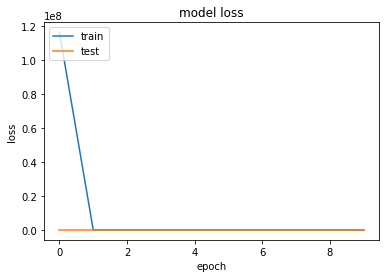

In [24]:
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [40]:
# making annotations on validation data

#image_num = validation_labels[1] - validation_labels[0]
image_num = 100
images = np.zeros((image_num, input_shape[0], input_shape[1], input_shape[2]))
for i in range(image_num):
    img = preprocess.load_img(path + str(i+validation_labels[0])+'.png')
    img_array = preprocess.img_to_array(img)
    images[i] = img_array
    
# preprocessing images (range from 0 to 1)
images /= 255.0


x_pred = images
y_pred = labels[validation_labels[0]:validation_labels[0]+image_num]
preds = model.predict(x_pred, verbose=1)

100/100 [==============================] - 3s 27ms/step


In [41]:
preds[:,0] = preds[:,0]*150 + 150
preds[:,1] = preds[:,1]*-100 + 100
preds = np.round(preds)

[[152. 102.]
 [152. 102.]
 [152. 102.]
 [152. 102.]
 [152. 102.]
 [152. 102.]
 [152. 102.]
 [153. 103.]
 [153. 103.]
 [152. 102.]
 [152. 102.]
 [152. 102.]
 [152. 102.]
 [152. 102.]
 [152. 102.]
 [152. 102.]
 [152. 102.]
 [152. 102.]
 [152. 102.]
 [152. 102.]
 [152. 102.]
 [152. 102.]
 [152. 103.]
 [152. 102.]
 [152. 102.]
 [152. 102.]
 [152. 102.]
 [152. 102.]
 [152. 102.]
 [152. 102.]
 [152. 102.]
 [152. 102.]
 [152. 102.]
 [152. 102.]
 [152. 102.]
 [152. 102.]
 [152. 102.]
 [152. 102.]
 [152. 102.]
 [152. 102.]
 [152. 102.]
 [152. 102.]
 [152. 102.]
 [152. 102.]
 [152. 102.]
 [152. 102.]
 [152. 102.]
 [152. 102.]
 [152. 102.]
 [154. 103.]
 [152. 102.]
 [152. 102.]
 [152. 102.]
 [152. 102.]
 [152. 102.]
 [152. 102.]
 [152. 102.]
 [152. 102.]
 [152. 102.]
 [153. 102.]
 [152. 102.]
 [152. 102.]
 [153. 103.]
 [152. 102.]
 [152. 102.]
 [152. 102.]
 [152. 102.]
 [152. 102.]
 [152. 102.]
 [152. 102.]
 [152. 102.]
 [152. 102.]
 [152. 102.]
 [152. 102.]
 [152. 102.]
 [152. 102.]
 [152. 102.]

In [42]:
from PIL import ImageDraw

for i in range(validation_labels[0],validation_labels[0]+image_num):
    img = Image.open(path + str(i)+'.png')
    draw = ImageDraw.Draw(img)
    
    pred = preds[i-validation_labels[0]]
    
    draw.line([tuple(pred - [10, 0]), tuple(pred + [10, 0])], fill="blue", width=3)
    draw.line([tuple(pred - [0, 10]), tuple(pred + [0, 10])], fill="red", width=3)

#    draw.point(labels_orig[i], fill="blue")
#    draw.point(preds[i-15840], fill="black")
    print(labels_orig[i], pred, labels_orig[i]- pred)
    img.save(path + "preds_cpu/" + str(i) + "_pred.png")

[118.  79.] [152. 102.] [-34. -23.]
[122.  78.] [152. 102.] [-30. -24.]
[143. 139.] [152. 102.] [-9. 37.]
[127. 100.] [152. 102.] [-25.  -2.]
[159. 109.] [152. 102.] [7. 7.]
[159.  81.] [152. 102.] [  7. -21.]
[170. 105.] [152. 102.] [18.  3.]
[143.  90.] [153. 103.] [-10. -13.]
[226. 127.] [153. 103.] [73. 24.]
[122. 130.] [152. 102.] [-30.  28.]
[ 88. 132.] [152. 102.] [-64.  30.]
[130.  65.] [152. 102.] [-22. -37.]
[157.  82.] [152. 102.] [  5. -20.]
[155.  97.] [152. 102.] [ 3. -5.]
[142. 122.] [152. 102.] [-10.  20.]
[176.  98.] [152. 102.] [24. -4.]
[186.  99.] [152. 102.] [34. -3.]
[213.  70.] [152. 102.] [ 61. -32.]
[189.  94.] [152. 102.] [37. -8.]
[140.  85.] [152. 102.] [-12. -17.]
[155.  72.] [152. 102.] [  3. -30.]
[126.  77.] [152. 102.] [-26. -25.]
[145.  97.] [152. 103.] [-7. -6.]
[179.  92.] [152. 102.] [ 27. -10.]
[187. 111.] [152. 102.] [35.  9.]
[132.  83.] [152. 102.] [-20. -19.]
[162.  97.] [152. 102.] [10. -5.]
[165. 104.] [152. 102.] [13.  2.]
[135.  75.] [152. 

In [43]:
# making predictions on test data

test_image_num = 4500

test_images = np.zeros((test_image_num, input_shape[0], input_shape[1], input_shape[2]))
for i in range(test_image_num):
    img = preprocess.load_img(path + "test/" + str(i)+'.png')
    img_array = preprocess.img_to_array(img)
    test_images[i] = img_array
    
# preprocessing images (range from 0 to 1)
test_images /= 255.0


test_x_pred = test_images


# importing test labels
f = open(path + "test/" + 'labels.txt', 'r')
test_labels = f.readlines()
test_labels = [eval(x.strip()) for x in test_labels]

# change labels to range from 0-num of pixels
test_labels = [(x[0] * 300, x[1] * 200) for x in test_labels]

test_y_pred = test_labels

In [44]:
# making predictions on test data
test_preds = model.predict(test_x_pred, verbose=1)

# converting to pixel locations
test_preds[:,0] = test_preds[:,0]*150 + 150
test_preds[:,1] = test_preds[:,1]*-100 + 100
test_preds = np.round(test_preds)
print(test_preds)

4500/4500 [==============================] - 194s 43ms/step
[[152. 102.]
 [152. 102.]
 [152. 102.]
 ...
 [152. 102.]
 [152. 102.]
 [152. 102.]]


In [25]:
# evaluating and printing results on test data
test_results = model.evaluate(x=test_x_pred, y=test_y_pred)

print(test_results)

In [26]:
from PIL import ImageDraw

for i in range(test_image_num):
    img = Image.open(path + "test/"+ str(i)+'.png')
    draw = ImageDraw.Draw(img)
    
    pred = test_preds[i-15840]
    
    draw.line([tuple(pred - [10, 0]), tuple(pred + [10, 0])], fill="blue", width=3)
    draw.line([tuple(pred - [0, 10]), tuple(pred + [0, 10])], fill="red", width=3)

#    draw.point(labels_orig[i], fill="blue")
#    draw.point(preds[i-12000], fill="black")
    print(labels_orig[i], test_preds[i], labels_orig[i]- test_preds[i])
    img.save(path + "test/" + "preds_cpu/" + str(i) + "_pred.png")

[106.  50.] [104. 138.] [  2. -88.]
[156. 115.] [154.  93.] [ 2. 22.]
[127. 114.] [123.  94.] [ 4. 20.]
[124.  68.] [121. 111.] [  3. -43.]
[164.  83.] [154. 100.] [ 10. -17.]
[153.  63.] [153. 131.] [  0. -68.]
[163.  69.] [148. 124.] [ 15. -55.]
[132.  90.] [159. 117.] [-27. -27.]
[198. 102.] [166.  97.] [32.  5.]
[132.  66.] [143. 114.] [-11. -48.]
[116.  80.] [146. 106.] [-30. -26.]
[133. 101.] [142. 101.] [-9.  0.]
[193. 125.] [181.  94.] [12. 31.]
[141.  96.] [126. 101.] [15. -5.]
[137.  82.] [141. 118.] [ -4. -36.]
[115.  79.] [128. 105.] [-13. -26.]
[195.  71.] [184. 123.] [ 11. -52.]
[97. 64.] [117. 125.] [-20. -61.]
[163. 152.] [150.  73.] [13. 79.]
[165.  85.] [153. 109.] [ 12. -24.]
[140. 100.] [116. 102.] [24. -2.]
[145.  71.] [137. 116.] [  8. -45.]
[ 89. 100.] [117. 106.] [-28.  -6.]
[166.  90.] [162. 102.] [  4. -12.]
[130. 156.] [117.  59.] [13. 97.]
[148.  82.] [149. 112.] [ -1. -30.]
[122. 128.] [122.  74.] [ 0. 54.]
[79. 84.] [ 91. 120.] [-12. -36.]
[137.  76.] [135

[137. 141.] [131.  73.] [ 6. 68.]
[190.  63.] [222. 140.] [-32. -77.]
[177. 125.] [198.  52.] [-21.  73.]
[165. 103.] [149. 112.] [16. -9.]
[127.  85.] [129. 114.] [ -2. -29.]
[178. 113.] [160.  95.] [18. 18.]
[129.  99.] [112.  93.] [17.  6.]
[116. 130.] [111.  80.] [ 5. 50.]
[154.  55.] [152. 110.] [  2. -55.]
[208.  80.] [180.  97.] [ 28. -17.]
[110.  99.] [118.  98.] [-8.  1.]
[158. 111.] [157.  90.] [ 1. 21.]
[137. 119.] [152.  82.] [-15.  37.]
[150. 110.] [153.  93.] [-3. 17.]
[118. 123.] [129.  86.] [-11.  37.]
[112. 129.] [130.  62.] [-18.  67.]
[141. 146.] [148.  81.] [-7. 65.]
[156.  56.] [155. 148.] [  1. -92.]
[159. 103.] [171. 100.] [-12.   3.]
[142. 145.] [105.  57.] [37. 88.]
[110. 100.] [97. 73.] [13. 27.]
[119. 131.] [157.  81.] [-38.  50.]
[184. 116.] [197.  49.] [-13.  67.]
[128. 133.] [131.  65.] [-3. 68.]
[98. 99.] [ 63. 110.] [ 35. -11.]
[161. 130.] [159.  85.] [ 2. 45.]
[132.  84.] [130. 114.] [  2. -30.]
[178.  81.] [150.  94.] [ 28. -13.]
[106. 113.] [101. 116.

[180. 128.] [163.  86.] [17. 42.]
[140.  74.] [111. 163.] [ 29. -89.]
[124. 128.] [145.  80.] [-21.  48.]
[126. 103.] [126. 101.] [0. 2.]
[184. 115.] [174.  86.] [10. 29.]
[117.  77.] [143. 112.] [-26. -35.]
[88. 98.] [107.  94.] [-19.   4.]
[219. 103.] [209. 114.] [ 10. -11.]
[168. 135.] [189.  71.] [-21.  64.]
[120. 105.] [124.  92.] [-4. 13.]
[105.  83.] [ 93. 112.] [ 12. -29.]
[162. 130.] [149.  81.] [13. 49.]
[148. 123.] [157.  94.] [-9. 29.]
[176. 145.] [199.  81.] [-23.  64.]
[122. 124.] [134.  89.] [-12.  35.]
[124. 100.] [121.  86.] [ 3. 14.]
[115. 100.] [140. 102.] [-25.  -2.]
[185. 101.] [172. 100.] [13.  1.]
[202. 126.] [163.  91.] [39. 35.]
[174. 106.] [163.  79.] [11. 27.]
[125. 110.] [134.  93.] [-9. 17.]
[207.  91.] [237. 135.] [-30. -44.]
[157.  91.] [149. 111.] [  8. -20.]
[153. 141.] [155.  94.] [-2. 47.]
[114.  99.] [120.  98.] [-6.  1.]
[140.  73.] [148. 129.] [ -8. -56.]
[161. 117.] [174.  88.] [-13.  29.]
[146. 101.] [165.  94.] [-19.   7.]
[131. 125.] [135.  77.

[158.  54.] [149. 111.] [  9. -57.]
[129.  85.] [123. 119.] [  6. -34.]
[156.  45.] [153. 141.] [  3. -96.]
[229.  74.] [161. 111.] [ 68. -37.]
[121.  77.] [132. 125.] [-11. -48.]
[189.  78.] [203. 130.] [-14. -52.]
[120.  83.] [129. 110.] [ -9. -27.]
[155.  88.] [122. 112.] [ 33. -24.]
[152. 156.] [158.  66.] [-6. 90.]
[183. 100.] [151.  95.] [32.  5.]
[104.  84.] [143. 101.] [-39. -17.]
[83. 49.] [112. 120.] [-29. -71.]
[125. 112.] [166. 114.] [-41.  -2.]
[176.  79.] [163. 125.] [ 13. -46.]
[129. 146.] [142.  65.] [-13.  81.]
[190. 109.] [166.  69.] [24. 40.]
[168.  97.] [164.  98.] [ 4. -1.]
[81. 71.] [133. 108.] [-52. -37.]
[151. 121.] [133.  86.] [18. 35.]
[112.  94.] [127. 150.] [-15. -56.]
[164.  79.] [147. 110.] [ 17. -31.]
[201. 113.] [156.  96.] [45. 17.]
[167. 144.] [150.  55.] [17. 89.]
[136. 127.] [167.  78.] [-31.  49.]
[160.  89.] [152. 101.] [  8. -12.]
[147.  77.] [132. 126.] [ 15. -49.]
[159.  66.] [150. 121.] [  9. -55.]
[142.  71.] [174. 118.] [-32. -47.]
[143. 106.

[207.  92.] [241. 114.] [-34. -22.]
[177.  59.] [150. 104.] [ 27. -45.]
[116.  81.] [140. 107.] [-24. -26.]
[192.  81.] [172. 104.] [ 20. -23.]
[123.  94.] [120. 108.] [  3. -14.]
[129.  84.] [143. 111.] [-14. -27.]
[118.  89.] [133. 115.] [-15. -26.]
[159. 127.] [160.  62.] [-1. 65.]
[117. 105.] [130.  93.] [-13.  12.]
[123. 142.] [139.  60.] [-16.  82.]
[148. 145.] [162.  83.] [-14.  62.]
[192.  91.] [159. 101.] [ 33. -10.]
[160. 126.] [143.  79.] [17. 47.]
[134.  75.] [139. 113.] [ -5. -38.]
[125. 110.] [143.  86.] [-18.  24.]
[132.  87.] [115. 115.] [ 17. -28.]
[205. 139.] [188. 106.] [17. 33.]
[170. 144.] [170.  46.] [ 0. 98.]
[150.  63.] [185. 188.] [ -35. -125.]
[161. 101.] [173.  86.] [-12.  15.]
[163.  79.] [161. 124.] [  2. -45.]
[151. 105.] [142.  89.] [ 9. 16.]
[170.  97.] [173.  90.] [-3.  7.]
[157.  85.] [137.  94.] [20. -9.]
[178.  67.] [161. 108.] [ 17. -41.]
[134. 133.] [157.  86.] [-23.  47.]
[186.  71.] [155. 124.] [ 31. -53.]
[105.  68.] [137. 104.] [-32. -36.]
[152

[146. 119.] [163.  73.] [-17.  46.]
[173. 125.] [185.  77.] [-12.  48.]
[187. 112.] [171.  83.] [16. 29.]
[134. 112.] [163.  93.] [-29.  19.]
[212.  96.] [177. 106.] [ 35. -10.]
[178. 116.] [162.  97.] [16. 19.]
[156. 117.] [143. 108.] [13.  9.]
[142.  96.] [147. 106.] [ -5. -10.]
[ 85. 112.] [120. 109.] [-35.   3.]
[133.  94.] [146.  96.] [-13.  -2.]
[171. 101.] [179. 103.] [-8. -2.]
[110. 100.] [148.  89.] [-38.  11.]
[ 80. 118.] [55. 49.] [25. 69.]
[144.  97.] [135. 112.] [  9. -15.]
[167. 109.] [239. 101.] [-72.   8.]
[202.  88.] [214.  95.] [-12.  -7.]
[142. 127.] [146.  64.] [-4. 63.]
[158. 127.] [150.  98.] [ 8. 29.]
[172.  83.] [162. 105.] [ 10. -22.]
[195.  70.] [185. 105.] [ 10. -35.]
[167.  98.] [158. 102.] [ 9. -4.]
[142.  79.] [145. 115.] [ -3. -36.]
[149. 127.] [161.  80.] [-12.  47.]
[122. 129.] [123.  71.] [-1. 58.]
[168. 151.] [157.  79.] [11. 72.]
[122.  83.] [131. 133.] [ -9. -50.]
[137. 110.] [149.  99.] [-12.  11.]
[156.  64.] [147. 115.] [  9. -51.]
[152. 127.] [1

[174. 109.] [167.  97.] [ 7. 12.]
[170. 111.] [161.  82.] [ 9. 29.]
[107.  91.] [115. 106.] [ -8. -15.]
[120.  73.] [143. 107.] [-23. -34.]
[182. 123.] [171.  85.] [11. 38.]
[144. 130.] [155.  90.] [-11.  40.]
[184.  98.] [156. 104.] [28. -6.]
[187. 138.] [160.  90.] [27. 48.]
[140.  79.] [143. 112.] [ -3. -33.]
[93. 74.] [105. 121.] [-12. -47.]
[141. 148.] [142.  86.] [-1. 62.]
[125. 123.] [143.  86.] [-18.  37.]
[169.  86.] [151. 105.] [ 18. -19.]
[ 91. 107.] [121. 102.] [-30.   5.]
[159. 133.] [137.  67.] [22. 66.]
[179. 146.] [156.  97.] [23. 49.]
[124.  87.] [135. 116.] [-11. -29.]
[115. 114.] [112.  92.] [ 3. 22.]
[159. 121.] [160.  78.] [-1. 43.]
[152.  88.] [141. 105.] [ 11. -17.]
[152. 111.] [145.  80.] [ 7. 31.]
[157.  85.] [157. 117.] [  0. -32.]
[156.  61.] [162. 142.] [ -6. -81.]
[173. 146.] [147.  87.] [26. 59.]
[142. 123.] [139.  75.] [ 3. 48.]
[159. 107.] [140.  93.] [19. 14.]
[113.  78.] [148. 106.] [-35. -28.]
[171. 143.] [122. 107.] [49. 36.]
[143.  69.] [150. 101.] 

[164. 100.] [159. 106.] [ 5. -6.]
[152. 144.] [144.  75.] [ 8. 69.]
[97. 65.] [101. 136.] [ -4. -71.]
[172.  73.] [149. 102.] [ 23. -29.]
[180. 104.] [190.  88.] [-10.  16.]
[175.  77.] [169. 112.] [  6. -35.]
[156.  68.] [132. 110.] [ 24. -42.]
[182. 111.] [150.  97.] [32. 14.]
[152.  69.] [153. 107.] [ -1. -38.]
[98. 83.] [141. 101.] [-43. -18.]
[152.  69.] [161. 129.] [ -9. -60.]
[162. 137.] [156.  78.] [ 6. 59.]
[170. 125.] [181.  81.] [-11.  44.]
[154.  95.] [146.  98.] [ 8. -3.]
[172. 132.] [172.  74.] [ 0. 58.]
[191.  95.] [194. 114.] [ -3. -19.]
[140.  66.] [147. 110.] [ -7. -44.]
[167.  96.] [171. 101.] [-4. -5.]
[142.  86.] [144.  95.] [-2. -9.]
[241.  73.] [163. 105.] [ 78. -32.]
[146.  92.] [135. 104.] [ 11. -12.]
[150. 103.] [113. 142.] [ 37. -39.]
[135. 115.] [144.  92.] [-9. 23.]
[130. 130.] [136.  78.] [-6. 52.]
[171. 115.] [168.  94.] [ 3. 21.]
[172.  82.] [162. 113.] [ 10. -31.]
[165.  54.] [146. 179.] [  19. -125.]
[125. 123.] [126.  83.] [-1. 40.]
[146. 103.] [148. 

[148. 118.] [153.  98.] [-5. 20.]
[159.  85.] [138. 106.] [ 21. -21.]
[174. 117.] [171.  89.] [ 3. 28.]
[189. 116.] [126.  89.] [63. 27.]
[164.  71.] [151. 106.] [ 13. -35.]
[108.  85.] [140.  86.] [-32.  -1.]
[187. 116.] [151. 101.] [36. 15.]
[151.  96.] [142.  88.] [9. 8.]
[152.  95.] [145. 100.] [ 7. -5.]
[170. 130.] [176.  63.] [-6. 67.]
[121.  76.] [143.  98.] [-22. -22.]
[102. 132.] [126.  56.] [-24.  76.]
[163. 102.] [149.  99.] [14.  3.]
[222.  91.] [276. 113.] [-54. -22.]
[145. 117.] [136.  89.] [ 9. 28.]
[178.  75.] [151.  99.] [ 27. -24.]
[145. 140.] [153.  86.] [-8. 54.]
[145.  68.] [150. 110.] [ -5. -42.]
[152. 143.] [140.  49.] [12. 94.]
[133. 131.] [115.  49.] [18. 82.]
[202.  68.] [172. 130.] [ 30. -62.]
[235. 111.] [212.  93.] [23. 18.]
[161.  85.] [175. 128.] [-14. -43.]
[142.  85.] [151. 126.] [ -9. -41.]
[196.  57.] [183. 134.] [ 13. -77.]
[142.  91.] [154.  96.] [-12.  -5.]
[125. 102.] [119. 107.] [ 6. -5.]
[163. 124.] [163.  70.] [ 0. 54.]
[188.  85.] [182.  99.] 

In [ ]:
# SAVE THE MODEL IF IT'S GOOD
model.save_weights('/home/hippoc/schen/models/300_200_resnet8_gates_model_shitty.h5')